# Disaster Tweets (Kaggle Challenge)


https://www.kaggle.com/competitions/nlp-getting-started/overview



In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from sklearn.pipeline import make_pipeline


In [2]:
twitter_df = pd.read_csv("datasets/train_dis.csv")

#### Check whether any data is missing

<Axes: >

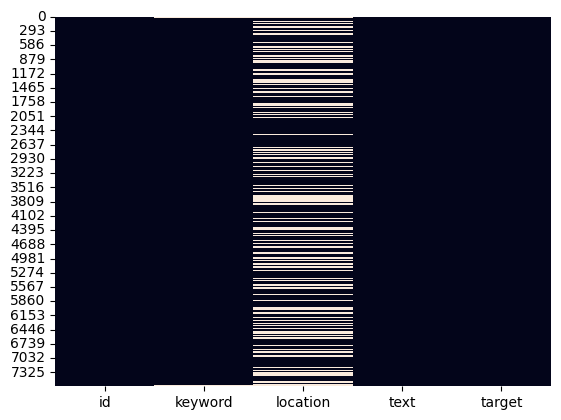

In [3]:
sns.heatmap(twitter_df.isnull(), cbar=False)

#### Check that we indeed have 2 classes


In [4]:
twitter_df.target.unique()

array([1, 0])

#### Check distributions

In [5]:
twitter_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target'>

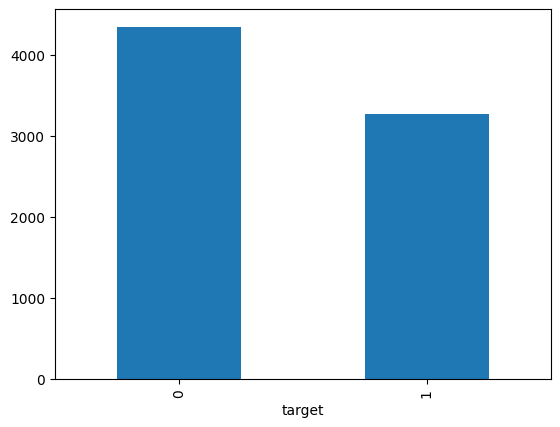

In [6]:
twitter_df.target.value_counts().plot.bar()


#### Set test set aside

In [7]:
test_set_kaggle = pd.read_csv("datasets/test_dis.csv")

In [8]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer

tt = TweetTokenizer()
stemmer = SnowballStemmer('english')


def preprocess_tweet(text):

    text = text.lower()
    
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr ', text)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr ',
                     cleaned)
    cleaned = re.sub(r'£|\$|\€', 'moneysymb ', cleaned) 
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr ', cleaned)
    cleaned = re.sub(r'\s\d+(\.\d+)?', ' numbr ', cleaned)   #\s added 
    
    tokenised = tt.tokenize(cleaned)
    
    tokenised_stem = []
    
    for i in tokenised:
        if len(i) >= 2:
            tokenised_stem.append(stemmer.stem(i))
            
    final_output = " ".join(tokenised_stem)
    
    return final_output

## Baseline

In [9]:
train_set_X = twitter_df.text
train_set_y = twitter_df.target

In [10]:
mnb = MultinomialNB()

text_transformer = make_pipeline(CountVectorizer(binary=True))
pipeline = make_pipeline(text_transformer, mnb)

In [11]:
baseline_model = pipeline.fit(train_set_X, train_set_y)  
y_predicted = baseline_model.predict(test_set_kaggle.text)
test_set_kaggle["target"] = y_predicted
test_set_kaggle[["id", "target"]].to_csv("datasets/submission_baseline.csv", index=False)

Upload it to Kaggle...

#### kaggle competition baseline with MNB 0.79528

In [12]:
#cross validation on train set using MNB

pipeline = make_pipeline(text_transformer, mnb)
scores = cross_val_score(pipeline, twitter_df.text, twitter_df.target, cv=10)#, scoring="f1_weighted")
scores.mean() 

0.7030130267882087

### Parameter search for Vectoriser

In [13]:
#experiment here
text_transformer = make_pipeline(CountVectorizer(binary=True,min_df=2, token_pattern="\S+"))
pipeline = make_pipeline(text_transformer, mnb)

In [14]:
scores = cross_val_score(pipeline, twitter_df.text, twitter_df.target, cv=10) #, scoring="f1_weighted")

In [15]:
scores.mean()  

0.7123390620850449

In [16]:
### let's try tfidf

text_transformer = make_pipeline(TfidfVectorizer(binary=False, min_df=2,token_pattern="\S+"))   #token_pattern="\S+"
pipeline = make_pipeline(text_transformer, mnb)

In [17]:
scores = cross_val_score(pipeline,  twitter_df.text,  twitter_df.target, cv=10, scoring="f1_weighted")

In [18]:
scores.mean() 

0.7077406654589615

## Changing Classifier

In [19]:
lg = LogisticRegression(max_iter=750)

In [20]:
pipeline = make_pipeline(text_transformer, lg)

In [21]:
#this will take a few seconds...

scores = cross_val_score(pipeline, twitter_df.text, twitter_df.target, cv=5)#, scoring="f1_weighted")

In [22]:
scores.mean() 

0.7273105419054136

In [23]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier

svm =SVC()
knn = KNeighborsClassifier()
dt = tree.DecisionTreeClassifier()
mlp = MLPClassifier(early_stopping=True)

In [24]:
#SVM performed the best
pipeline = make_pipeline(text_transformer, svm)
scores = cross_val_score(pipeline, twitter_df.text, twitter_df.target, cv=5)
scores.mean() 

0.7266550647409885

## Applying preprocessing function

In [25]:
#with stemming we get a higher result stemming
twitter_df["text_clean_stem"] = twitter_df.text.apply(preprocess_tweet)
scores = cross_val_score(pipeline, twitter_df.text_clean_stem, twitter_df.target, cv=5)
scores.mean() 

0.7246875978750702

## Saving wrong predictions to file for analysis

In [26]:
# need to create separate validation set

X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(twitter_df.text_clean_stem, twitter_df.target, test_size=0.2,stratify=twitter_df.target,
                                                                                random_state=40)

In [27]:
rf_model = pipeline.fit(X_temp_train,y_temp_train)

In [28]:
y_preds = rf_model.predict(X_temp_test)

In [29]:
y_df = pd.DataFrame({"text": X_temp_test, "real_target": y_temp_test, "predicted_target": y_preds})
wrong_df = y_df[y_df.real_target != y_df.predicted_target]

In [30]:
print(classification_report(y_temp_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       869
           1       0.87      0.67      0.76       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523



In [31]:
wrong_df

,text,real_target,predicted_target
286,rt our_mother_mari short read apocalyps numbr ...,0,1
1424,@irishspi what you don't think the alli should...,1,0
3629,injuri ill and fatal latest number httpaddr,1,0
5445,episcop priest on road trip with interraci fam...,0,1
6239,@habbo bring back game from the past snowstorm...,1,0
...,...,...,...
5339,@khalidkkazi mate they'v taken anoth numbr sin...,1,0
7180,pleas allow me to reiter it not the weapon it ...,1,0
1437,benzema increas look to be casualti of benitez...,1,0
4541,httpaddr seem they declar war against govern ..,1,0


In [33]:
wrong_df.to_csv("datasets/wrong_predictions_dis.csv")

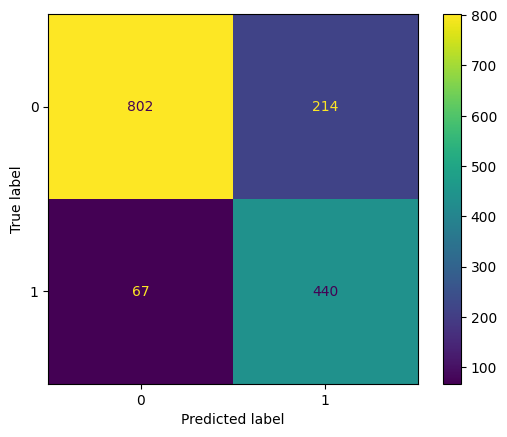

In [33]:
cm = confusion_matrix(y_preds, y_temp_test, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()


In [34]:
train_set_count = CountVectorizer(binary=True,min_df=2, token_pattern="\S+").fit_transform(twitter_df.text_clean_stem)

### Searching for best hyper-parameters

For SVMs there are hyper-parameters like the `C` parameter, `kernel` or `gamma`. We can try to find the best parameters manually, but it is much better to perform Grid Search. Let's run it! **Note: This may take a lot of time!**

Regularisation generally refers the concept that there should be a complexity penalty for more extreme parameters. The idea is that just looking at the training data and not paying attention to how extreme one's parameters are leads to overfitting. A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it".

In [154]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {'C': np.linspace(0.1, 2, 10),"kernel":["linear", "rbf", "sigmoid"]}
grid_search = GridSearchCV(SVC(), parameters)
grid_search.fit(train_set_count,twitter_df.target)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

best parameters:  {'C': 0.7333333333333333, 'kernel': 'rbf'}
best scores:  0.7388723756539026


In [46]:
svc = SVC(C=0.75)
final_pipeline = make_pipeline(text_transformer, svc)
scores = cross_val_score(final_pipeline, twitter_df.text_clean_stem, twitter_df.target, cv=5)
scores.mean() 


0.738478934049351

### let's test it on the test set

In [47]:
# clean text
test_set_kaggle["text_clean_stem"] = test_set_kaggle.text.apply(preprocess_tweet)
final_model = final_pipeline.fit(twitter_df.text_clean_stem,twitter_df.target)
y_predicted = final_model.predict(test_set_kaggle.text_clean_stem)

In [48]:
test_set_kaggle[["id", "target"]].to_csv("datasets/submission_final.csv", index=False)